In [16]:
import os
import random
from ultralytics import YOLO
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [67]:
def segmentar_imagen_yolo(model_path, image_folder):
    """
    Realiza la segmentación de una imagen seleccionada aleatoriamente desde un folder usando YOLOv8.

    Parámetros:
    - model_path: Ruta al modelo YOLO entrenado (.pt).
    - image_folder: Carpeta que contiene imágenes para segmentar.

    Retorna:
    - masks: Lista de arrays con las coordenadas de cada máscara detectada.
    """
    # Seleccionar una imagen al azar de la carpeta
    image_files = [f for f in os.listdir(image_folder) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    if not image_files:
        raise ValueError("No se encontraron imágenes en la carpeta especificada.")
    
    random_image = random.choice(image_files)
    image_path = os.path.join(image_folder, random_image)
    print(f"Imagen seleccionada: {image_path}")

    # Cargar el modelo entrenado
    model = YOLO(model_path)

    # Realizar la predicción en la imagen
    results = model(image_path)

    # Cargar la imagen original
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Variable para almacenar las coordenadas de las máscaras
    masks = []

    # Procesar los resultados y extraer las máscaras
    for result in results:
        if result.masks is not None:
            for mask in result.masks.xy:  # Obtener coordenadas de las máscaras
                masks.append(mask)  # Guardar en la variable
                
                # Dibujar la máscara en la imagen
                pts = np.array(mask, dtype=np.int32)
                cv2.polylines(image, [pts], isClosed=True, color=(255, 0, 0), thickness=2)

    # Mostrar la imagen con los contornos segmentados
    plt.figure(figsize=(10, 10))
    plt.imshow(image)
    plt.axis("off")
    plt.show()

    return masks

Imagen seleccionada: /home/nahumfg/Projects/GithubProjects/TesisTransparenciaDataset/data/c_label_studio_straight/split/val/images/1af96aca-001_Asis_vot_OFICIAL_2-02-22_page_40.png

image 1/1 /home/nahumfg/Projects/GithubProjects/TesisTransparenciaDataset/data/c_label_studio_straight/split/val/images/1af96aca-001_Asis_vot_OFICIAL_2-02-22_page_40.png: 640x480 1 documento, 19.5ms
Speed: 2.1ms preprocess, 19.5ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 480)


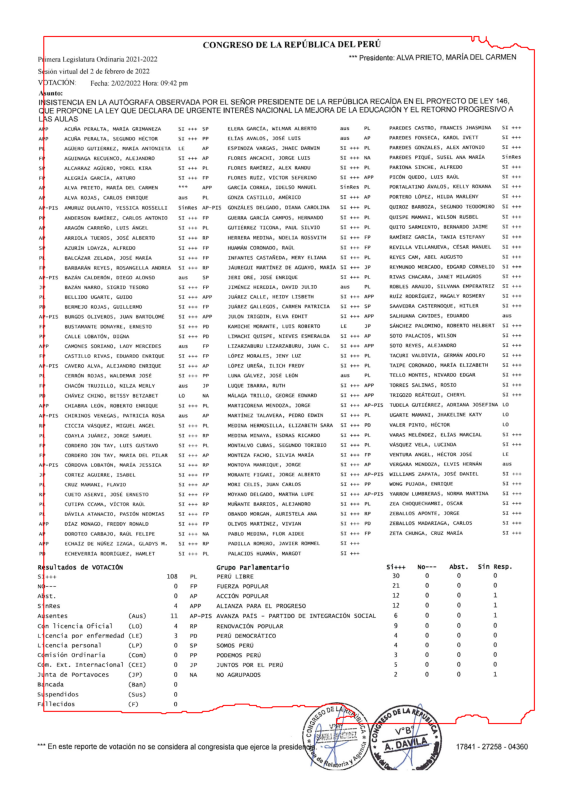

In [68]:
# Uso
model_path = "train_logs/yolov8s-seg3/weights/best.pt"
image_folder = "/home/nahumfg/Projects/GithubProjects/TesisTransparenciaDataset/data/c_label_studio_straight/split/val/images"

masks = segmentar_imagen_yolo(model_path, image_folder)

# 2. YOLO + extremos

In [84]:
import torch
from ultralytics import YOLO
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
import random

def segmentar_imagen_yolo_rotado(model_path, image_folder):
    """
    Segmenta una imagen aleatoria con YOLOv8, amplía los rectángulos rotados,
    y visualiza incluso aquellos que se salen del borde original mediante padding.

    Parámetros:
    - model_path: Ruta al modelo YOLO entrenado (.pt).
    - image_folder: Carpeta que contiene las imágenes.

    Retorna:
    - rotated_boxes: Lista de arrays con las coordenadas de cada rectángulo rotado detectado.
    """
    # Obtener lista de imágenes válidas
    image_files = [f for f in os.listdir(image_folder) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    if not image_files:
        raise ValueError("No se encontraron imágenes en la carpeta especificada.")
    
    # Seleccionar una imagen al azar
    random_image = random.choice(image_files)
    image_path = os.path.join(image_folder, random_image)
    print(f"Imagen seleccionada: {image_path}")

    # Cargar el modelo entrenado
    model = YOLO(model_path)

    # Realizar la predicción en la imagen
    results = model(image_path)

    # Cargar la imagen original
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    height, width = image.shape[:2]

    # Agregar padding alrededor (10% horizontal y vertical)
    pad_x = int(0.1 * width)
    pad_y = int(0.1 * height)
    padded_image = cv2.copyMakeBorder(
        image, pad_y, pad_y, pad_x, pad_x,
        borderType=cv2.BORDER_CONSTANT,
        value=(255, 255, 255)  # fondo blanco
    )

    # Lista para almacenar los rectángulos rotados
    rotated_boxes = []

    # Procesar los resultados y extraer las máscaras
    for result in results:
        if result.masks is not None:
            for mask in result.masks.xy:
                mask = np.array(mask)

                # Obtener el rectángulo rotado mínimo
                rect = cv2.minAreaRect(mask.astype(np.float32))  # ((cx, cy), (w, h), angle)
                (cx, cy), (w, h), angle = rect

                # Ampliar w (x) un 10% y h (y) un 5%
                w *= 1.30
                h *= 1.00

                # Ajustar centro por el padding (desplazar las cajas)
                rect_ampliado = ((cx + pad_x, cy + pad_y), (w, h), angle)
                box = cv2.boxPoints(rect_ampliado)
                box = np.int0(box)

                rotated_boxes.append(box)

                # Dibujar el rectángulo en la imagen con padding
                cv2.polylines(padded_image, [box], isClosed=True, color=(255, 0, 0), thickness=2)

    # Mostrar la imagen ampliada
    plt.figure(figsize=(10, 10))
    plt.imshow(padded_image)
    plt.axis("off")
    plt.show()

    return rotated_boxes


Imagen seleccionada: /home/nahumfg/Projects/GithubProjects/TesisTransparenciaDataset/data/c_label_studio_straight/split/val/images/61eef2e7-008_0-AS-VOT-25-05-17-OFICIAL_page_34.png

image 1/1 /home/nahumfg/Projects/GithubProjects/TesisTransparenciaDataset/data/c_label_studio_straight/split/val/images/61eef2e7-008_0-AS-VOT-25-05-17-OFICIAL_page_34.png: 640x480 1 documento, 18.1ms
Speed: 2.2ms preprocess, 18.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 480)


/tmp/ipykernel_902184/2912676422.py:71: DeprecationWarning: `np.int0` is a deprecated alias for `np.intp`.  (Deprecated NumPy 1.24)
  box = np.int0(box)


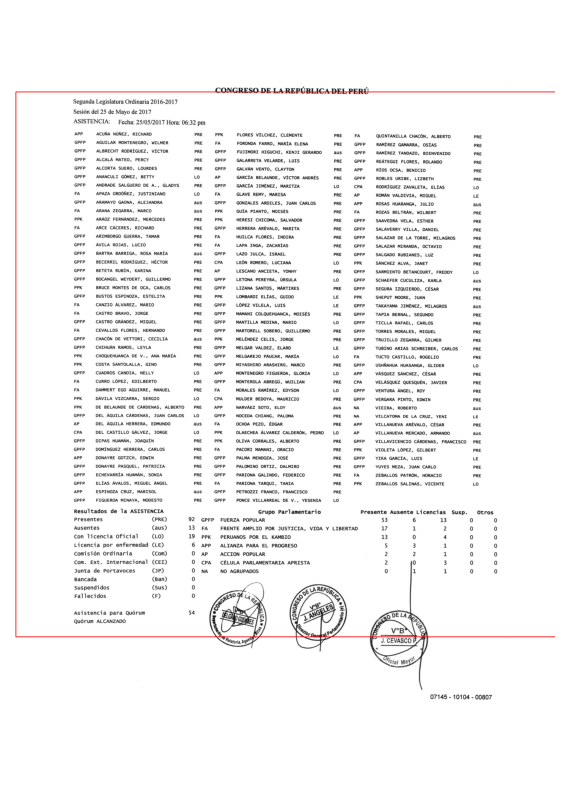

In [88]:
# Uso
model_path = "train_logs/yolov8s-seg3/weights/best.pt"
image_folder = "/home/nahumfg/Projects/GithubProjects/TesisTransparenciaDataset/data/c_label_studio_straight/split/val/images"

masks = segmentar_imagen_yolo_rotado(model_path, image_folder)